# **CARTPOLE DDQN KERAS**

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import random
import gymnasium as gym
import time
import numpy as np
from collections import deque
from keras.models import Sequential, Model
from keras.layers import Dense, Input
from keras.optimizers import Adam
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf

# Use mixed-precision training for faster computations on supported GPUs
from tensorflow.keras.mixed_precision import set_global_policy
set_global_policy('mixed_float16')

import sys
sys.stderr = open('err.txt', 'w')

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3060, compute capability 8.6


In [2]:
from tensorflow.python.client import device_lib
devices = device_lib.list_local_devices()
gpu_devices = [device for device in devices if device.device_type == 'GPU']
for gpu in gpu_devices:
    print('Using', gpu.physical_device_desc)

Using device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:01:00.0, compute capability: 8.6


In [16]:
# Parameters to fine tune
# Try your own parameters
# Remember epsilon and gamma are very important


MAX_EPISODES = 300
ROLLING_WINDOW = 20
MEMORY_SIZE = 2000
MAX_STEPS = 500

gamma = 0.99                        # discount rate
epsilon = 1.0                        # exploration rate
epsilon_min = 0.01
epsilon_decay = 0.99
learning_rate = 0.001
batch_size = 64
solved_threshold = 195

verb = 0                             # to see traces (verbosity)

In [17]:
# Environment setup
env = gym.make("CartPole-v1")
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

#### **Support Functions**

In [ ]:
replay_buffer = deque(maxlen=MEMORY_SIZE)

def store(state, action, reward, next_state, done):             
    """
    This function appends the actual observation and reward to the Replay buffer
    """
    state = state.squeeze()
    next_state = next_state.squeeze()
    replay_buffer.append((state, action, reward, next_state, done))

def select_action_greedy(state, model, epsilon):           
    """
    Selects action using epsilon-greedy policy
    """
    if np.random.rand() <= epsilon:
        return random.randrange(action_size)
    state = np.reshape(state, [1, state_size])
    act_values = model.predict(state, verbose=verb)
    return np.argmax(act_values[0])

# Sample experiences from the replay buffer
def sample_experiences(batch_size):
    """
    Samples a batch_size of experiences from the Replay buffer. 
    You MUST transform the data into numpy arrays as this accelerates the response time sensibily
    """
    indices = np.random.choice(len(replay_buffer), batch_size, replace=False)
    batch = [replay_buffer[i] for i in indices]
    states, actions, rewards, next_states, dones = zip(*batch)

    states = np.array(states)
    actions = np.array(actions)
    rewards = np.array(rewards)
    next_states = np.array(next_states)
    dones = np.array(dones)

    return (states, actions, rewards, next_states, dones)
    
def experience_replay(batch_size, model, epsilon):
    """
    The critical function in the whole program
    1. gets a minibatch from replay buffer
    2. Predicts targets_qs from states (we need the full batch predicted but we'll avoid dones)
    3. predicts next_qs from next_states
    4. Bellman equation on next_qs obtains new target_qs $Q_{\text{target}}(s_t, a_t) = r_t + \gamma \cdot \max_{a'} Q(s_{t+1}, a') \cdot (1 - \text{done})$

    6. Train DQN input states, output target_qs 

    """
    if len(replay_buffer) < batch_size:
        return

    states, actions, rewards, next_states, dones = sample_experiences(batch_size)
    
    target_qs = model.predict(states, verbose=verb) # Get current Q-values for all states
    next_qs = model.predict(next_states, verbose=verb) # Get next Q-values for next states

    # Update target Q-values using standard DQN logic   
    target_qs[np.arange(batch_size), actions] = rewards + gamma * np.max(next_qs, axis=1) * (1 - dones)
    
    # Train the model on the Q-values
    model.fit(states, target_qs, epochs=1, verbose=0)

def load(name, DQN):
    DQN.load_weights(name)

def save(name, DQN):
    DQN.save_weights(name)

## CartPole DDQN

Episode:   1/300, Reward:  +22.00, Epsilon: 0.43, Rolling Avg:  22.00, Steps:  21
Episode:   2/300, Reward:  +66.00, Epsilon: 0.43, Rolling Avg:  44.00, Steps:  65
Episode:   3/300, Reward:  +12.00, Epsilon: 0.42, Rolling Avg:  33.33, Steps:  11
Episode:   4/300, Reward:  +10.00, Epsilon: 0.42, Rolling Avg:  27.50, Steps:   9
Episode:   5/300, Reward:  +17.00, Epsilon: 0.41, Rolling Avg:  25.40, Steps:  16
Episode:   6/300, Reward:  +10.00, Epsilon: 0.41, Rolling Avg:  22.83, Steps:   9
Episode:   7/300, Reward:  +14.00, Epsilon: 0.40, Rolling Avg:  21.57, Steps:  13
Episode:   8/300, Reward:  +12.00, Epsilon: 0.40, Rolling Avg:  20.38, Steps:  11
Episode:   9/300, Reward:   +9.00, Epsilon: 0.40, Rolling Avg:  19.11, Steps:   8
Episode:  10/300, Reward:   +8.00, Epsilon: 0.39, Rolling Avg:  18.00, Steps:   7
Episode:  11/300, Reward:  +15.00, Epsilon: 0.39, Rolling Avg:  17.73, Steps:  14
Episode:  12/300, Reward:  +12.00, Epsilon: 0.38, Rolling Avg:  17.25, Steps:  11
Episode:  13/300

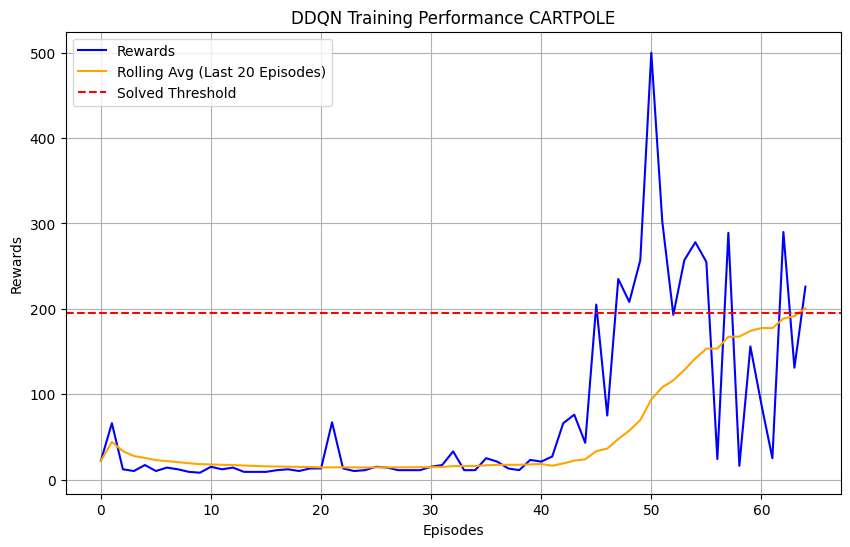

In [ ]:
# DDQN Cartpole

def build_model(state_size, action_size):
    inputs = Input(shape=(state_size,), name="state_input")
    x = Dense(24, activation='relu', name="dense_1")(inputs)
    x = Dense(24, activation='relu', name="dense_2")(x)
    outputs = Dense(action_size, activation='linear', name="output_layer")(x)
    
    model = Model(inputs=inputs, outputs=outputs, name="Q_Network")
    model.compile(loss='mse', optimizer=Adam(learning_rate=learning_rate))
    return model

# Create main and target networks
DQN = build_model(state_size, action_size)
target_DQN = build_model(state_size, action_size)
target_DQN.set_weights(DQN.get_weights()) # Initialize target network with main network weights

def update_target_network():
    """
    Update the target network with the main network weights
    """
    target_DQN.set_weights(DQN.get_weights())

def select_action_greedy(state, model, epsilon):
    """
    Selects action using epsilon-greedy policy
    """
    if np.random.rand() <= epsilon:
        return random.randrange(action_size)
    state = np.reshape(state, [1, state_size])
    act_values = model.predict(state, verbose=verb)
    return np.argmax(act_values[0])

def experience_replay(batch_size, model, epsilon):
    """
    Sample a batch of experiences from the replay buffer.
    Double DQN: Use the main network to select the action, and the target network to evaluate the Q-values.
    """
    if len(replay_buffer) < batch_size:
        return

    states, actions, rewards, next_states, dones = sample_experiences(batch_size)

    # Get current Q-values from the main network
    target_qs = model.predict(states, verbose=verb)

    # Double DQN: Use the main network to select the action, and the target network to evaluate the Q-values
    next_qs_main = model.predict(next_states, verbose=verb)  # Main network predicts next states
    next_qs_target = target_DQN.predict(next_states, verbose=verb)  # Target network predicts next states

    # Select the best action for each next state using the main network
    best_actions = np.argmax(next_qs_main, axis=1)

    # Get Q-values for the best actions from the target network
    best_qs = next_qs_target[np.arange(batch_size), best_actions]

    # Update the target Q-values using the Bellman equation
    target_qs[np.arange(batch_size), actions] = rewards + gamma * best_qs * (1 - dones)

    # Train the main network on the target Q-values
    model.fit(states, target_qs, epochs=1, verbose=0)

# Training loop for DDQN
rewards_per_episode = []
rolling_avg_rewards = []
rolling_avg = 0

start_time = time.time()

for episode in range(MAX_EPISODES):
    state, _ = env.reset()
    total_reward = 0
    
    for step in range(MAX_STEPS):
        action = select_action_greedy(state, DQN, epsilon)
        next_state, reward, done, truncated, _ = env.step(action)
        
        store(state, action, reward, next_state, done)
        state = next_state
        total_reward += reward
        
        if len(replay_buffer) > batch_size:
            experience_replay(batch_size, DQN, epsilon)
        
        if done or truncated:
            break
    
    # Update target network every 10 episodes
    if episode % 10 == 0:
        update_target_network()
    
    # Decay epsilon
    epsilon = max(epsilon_min, epsilon * epsilon_decay)
    
    # Track rewards
    rewards_per_episode.append(total_reward)
    rolling_avg = np.mean(rewards_per_episode[-ROLLING_WINDOW:])
    rolling_avg_rewards.append(rolling_avg)
    
    print(f"Episode: {episode+1:3}/{MAX_EPISODES}, Reward: {total_reward:+7.2f}, "
          f"Epsilon: {epsilon:.2f}, Rolling Avg: {rolling_avg:6.2f}, Steps: {step:3}")
    
    # Check if environment is solved
    if rolling_avg >= solved_threshold:
        print(f"Environment solved in {episode+1} episodes!")
        DQN.save("CartPole_ddqn_model.keras")
        break

end_time = time.time()
training_duration = (end_time - start_time) / 60  # Convert to minutes
print(f"Training completed in {training_duration:.2f} minutes")

# Plot training results
plt.figure(figsize=(10, 6))
plt.plot(rewards_per_episode, label='Rewards', color='blue')
plt.plot(rolling_avg_rewards, label='Rolling Avg (Last 20 Episodes)', color='orange')
plt.axhline(y=solved_threshold, color='red', linestyle='--', label='Solved Threshold')
plt.title('DDQN Training Performance CARTPOLE')
plt.xlabel('Episodes')
plt.ylabel('Rewards')
plt.legend()
plt.grid()
plt.show()

## Testing Frameworks

In [ ]:
import os
import numpy as np
import random
import time
from collections import deque
import gymnasium as gym
import matplotlib.pyplot as plt

from tensorflow.keras.mixed_precision import set_global_policy
set_global_policy('mixed_float16')

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam

# === Settings ===
MAX_EPISODES = 300
ROLLING_WINDOW = 20
MAX_STEPS = 500
gamma = 0.99
epsilon_min = 0.01
batch_size = 64
solved_threshold = 195
epsilon_start = 1.0
verb = 0
TARGET_UPDATE_FREQ = 10

# === Model Save Directory ===
MODEL_DIR = "models"
os.makedirs(MODEL_DIR, exist_ok=True)

# === Build Model ===
def build_model(state_size, action_size, network_structure=(64, 64), learning_rate=0.001):
    inputs = Input(shape=(state_size,))
    x = inputs
    for units in network_structure:
        x = Dense(units, activation='relu')(x)
    outputs = Dense(action_size, activation='linear')(x)
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(loss='mse', optimizer=Adam(learning_rate=learning_rate))
    return model

# === Replay Logic ===
def select_action_greedy(state, model, epsilon):
    if np.random.rand() <= epsilon:
        return random.randrange(model.output_shape[-1])
    q_values = model.predict(state[np.newaxis, :], verbose=verb)
    return np.argmax(q_values[0])

def store(state, action, reward, next_state, done):
    replay_buffer.append((state.squeeze(), action, reward, next_state.squeeze(), done))

def sample_experiences(batch_size):
    indices = np.random.choice(len(replay_buffer), batch_size, replace=False)
    batch = [replay_buffer[i] for i in indices]
    states, actions, rewards, next_states, dones = zip(*batch)
    return np.array(states), np.array(actions), np.array(rewards), np.array(next_states), np.array(dones)

def ddqn_experience_replay(main_model, target_model):
    if len(replay_buffer) < batch_size:
        return
        
    states, actions, rewards, next_states, dones = sample_experiences(batch_size)
    
    # Batch predictions together
    current_qs = main_model.predict(states, verbose=0)
    next_qs_main = main_model.predict(next_states, verbose=0)
    next_qs_target = target_model.predict(next_states, verbose=0)
    
    # Get next actions and compute targets
    next_actions = np.argmax(next_qs_main, axis=1)
    target_qs = current_qs.copy()
    target_qs[np.arange(batch_size), actions] = rewards + gamma * next_qs_target[np.arange(batch_size), next_actions] * (1 - dones)
    
    # Use train_on_batch instead of fit
    main_model.train_on_batch(states, target_qs)

def update_target_network(source_model, target_model):
    target_model.set_weights(source_model.get_weights())

# === Config Class ===
class ExperimentConfig:
    def __init__(self, network_structure=(64, 64), memory_size=2000,
                 learning_rate=0.001, epsilon_decay=0.99, name="default"):
        self.network_structure = network_structure
        self.memory_size = memory_size
        self.learning_rate = learning_rate
        self.epsilon_decay = epsilon_decay
        self.name = name
        self.algorithm = "DDQN"

# === Train One Configuration ===
def run_experiment(config):
    global replay_buffer
    env = gym.make("CartPole-v1")
    state_size = env.observation_space.shape[0]
    action_size = env.action_space.n

    main_model = build_model(state_size, action_size, config.network_structure, config.learning_rate)
    target_model = build_model(state_size, action_size, config.network_structure, config.learning_rate)
    update_target_network(main_model, target_model)

    replay_buffer = deque(maxlen=config.memory_size)
    epsilon = epsilon_start
    rewards_per_episode = []
    rolling_avg_rewards = []
    episodes_to_solve = None
    model_filename = None
    start_time = time.time()

    for episode in range(MAX_EPISODES):
        state, _ = env.reset()
        total_reward = 0

        for step in range(MAX_STEPS):
            action = select_action_greedy(state, main_model, epsilon)
            next_state, reward, done, truncated, _ = env.step(action)
            store(state, action, reward, next_state, done or truncated)
            state = next_state
            total_reward += reward

            if done or truncated:
                break

            if len(replay_buffer) >= batch_size:
                ddqn_experience_replay(main_model, target_model)

        if episode % TARGET_UPDATE_FREQ == 0:
            update_target_network(main_model, target_model)

        epsilon = max(epsilon_min, epsilon * config.epsilon_decay)
        rewards_per_episode.append(total_reward)
        rolling_avg = np.mean(rewards_per_episode[-ROLLING_WINDOW:])
        rolling_avg_rewards.append(rolling_avg)

        if (episode + 1) % 10 == 0 or episode == 0:
            print(f"Config: {config.name}, Ep: {episode+1:3}/{MAX_EPISODES}, "
                f"Reward: {total_reward:7.2f}, Epsilon: {epsilon:.2f}, "
                f"Rolling Avg: {rolling_avg:6.2f}")

        if rolling_avg >= solved_threshold and episodes_to_solve is None:
            episodes_to_solve = episode + 1
            model_filename = os.path.join(MODEL_DIR, f"CartPole_DDQN_{config.name}_solved.keras")
            main_model.save(model_filename)
            print(f"Model saved as {model_filename}")
            break

    training_duration = (time.time() - start_time) / 60
    if model_filename is None:
        model_filename = os.path.join(MODEL_DIR, f"CartPole_DDQN_{config.name}_final.keras")
        main_model.save(model_filename)
        print(f"Model saved as {model_filename}")

    return {
        'config': config,
        'episodes_to_solve': episodes_to_solve,
        'training_duration': training_duration,
        'rewards': rewards_per_episode,
        'rolling_avg': rolling_avg_rewards,
        'model_filename': model_filename
    }

# === Best Model Finder ===
def find_best_model(results):
    solved_models = [r for r in results if r['episodes_to_solve'] is not None]
    if not solved_models:
        print("No models reached the solved threshold!")
        return None

    best_model = min(solved_models, key=lambda x: (x['episodes_to_solve'], x['training_duration']))
    print("\nBest Model Found:")
    print("----------------")
    print(f"Configuration: {best_model['config'].name}")
    print(f"Algorithm: {best_model['config'].algorithm}")
    print(f"Network Structure: {best_model['config'].network_structure}")
    print(f"Memory Size: {best_model['config'].memory_size}")
    print(f"Learning Rate: {best_model['config'].learning_rate}")
    print(f"Epsilon Decay: {best_model['config'].epsilon_decay}")
    print(f"Episodes to Solve: {best_model['episodes_to_solve']}")
    print(f"Training Duration: {best_model['training_duration']:.2f} minutes")
    print(f"Model File: {best_model['model_filename']}")
    return best_model


In [ ]:

# === Define Experiments ===
experiments = [
    # Network structure comparison
    #ExperimentConfig(network_structure=(16, 32), name="DDQN_16-32"),
    ExperimentConfig(network_structure=(24, 24), name="DDQN_24-24"),
    ExperimentConfig(network_structure=(32, 32), name="DDQN_32-32"),

    # # Replay buffer comparison
    ExperimentConfig(memory_size=1000, name="DDQN_mem_1000"),
    # #ExperimentConfig(memory_size=2000, name="DDQN_mem_2000"),
    ExperimentConfig(memory_size=5000, name="DDQN_mem_5000"),

    # # Learning rate comparison
    ExperimentConfig(learning_rate=0.0001, name="DDQN_lr_0.0001"),
    # #ExperimentConfig(learning_rate=0.001, name="DDQN_lr_0.001"),
    ExperimentConfig(learning_rate=0.01, name="DDQN_lr_0.01"),

    # # Epsilon decay comparison
    ExperimentConfig(epsilon_decay=0.95, name="DDQN_eps_0.95"),
    # #ExperimentConfig(epsilon_decay=0.99, name="DDQN_eps_0.99"),
    ExperimentConfig(epsilon_decay=0.995, name="DDQN_eps_0.995"),
]

# === Run All Experiments ===
results = []
for config in experiments:
    print(f"\nRunning experiment: {config.name}")
    result = run_experiment(config)
    results.append(result)

# === Find Best Model ===
best_model = find_best_model(results)

# === Plot Results ===
def plot_experiment_results(results):
    plt.figure(figsize=(15, 10))
    for result in results:
        plt.plot(result['rolling_avg'], label=f"{result['config'].name}")
    plt.axhline(y=solved_threshold, color='red', linestyle='--', label='Solved Threshold')
    plt.title('Comparison of Different Configurations')
    plt.xlabel('Episodes')
    plt.ylabel('Rolling Average Reward')
    plt.legend()
    plt.grid()
    plt.show()

# === Print Summary ===
print("\nExperiment Results Summary:")
print("-------------------------")
for result in results:
    config = result['config']
    print(f"\nConfiguration: {config.name}")
    print(f"Network Structure: {config.network_structure}")
    print(f"Memory Size: {config.memory_size}")
    print(f"Learning Rate: {config.learning_rate}")
    print(f"Epsilon Decay: {config.epsilon_decay}")
    print(f"Episodes to Solve: {result['episodes_to_solve']}")
    print(f"Training Duration: {result['training_duration']:.2f} minutes")
    print(f"Model File: {result['model_filename']}")

plot_experiment_results(results)


Running experiment: DDQN_24-24
Config: DDQN_24-24, Ep:   1/300, Reward:   18.00, Epsilon: 0.99, Rolling Avg:  18.00
Config: DDQN_24-24, Ep:  10/300, Reward:   13.00, Epsilon: 0.90, Rolling Avg:  21.30
Config: DDQN_24-24, Ep:  20/300, Reward:   13.00, Epsilon: 0.82, Rolling Avg:  21.55
Config: DDQN_24-24, Ep:  30/300, Reward:   21.00, Epsilon: 0.74, Rolling Avg:  20.50
Config: DDQN_24-24, Ep:  40/300, Reward:   46.00, Epsilon: 0.67, Rolling Avg:  19.10
Config: DDQN_24-24, Ep:  50/300, Reward:   33.00, Epsilon: 0.61, Rolling Avg:  24.35
Config: DDQN_24-24, Ep:  60/300, Reward:   30.00, Epsilon: 0.55, Rolling Avg:  39.55
Config: DDQN_24-24, Ep:  70/300, Reward:   82.00, Epsilon: 0.49, Rolling Avg:  66.80
Config: DDQN_24-24, Ep:  80/300, Reward:  106.00, Epsilon: 0.45, Rolling Avg:  88.45
Config: DDQN_24-24, Ep:  90/300, Reward:  221.00, Epsilon: 0.40, Rolling Avg: 132.65
Config: DDQN_24-24, Ep: 100/300, Reward:   39.00, Epsilon: 0.37, Rolling Avg: 159.95
Config: DDQN_24-24, Ep: 110/300, 

Unfortunately it crashed right at the end (After roughly half a day of training) -- Would have been best to have it write to a json file after every model just incase this were to happen.


Running experiment: Comp_DDQN_mem_2000
Config: Comp_DDQN_mem_2000, Ep:   1/300, Reward:   11.00, Epsilon: 0.99, Rolling Avg:  11.00
Config: Comp_DDQN_mem_2000, Ep:  10/300, Reward:   12.00, Epsilon: 0.90, Rolling Avg:  25.10
Config: Comp_DDQN_mem_2000, Ep:  20/300, Reward:   31.00, Epsilon: 0.82, Rolling Avg:  21.40
Config: Comp_DDQN_mem_2000, Ep:  30/300, Reward:   15.00, Epsilon: 0.74, Rolling Avg:  16.50
Config: Comp_DDQN_mem_2000, Ep:  40/300, Reward:   15.00, Epsilon: 0.67, Rolling Avg:  20.75
Config: Comp_DDQN_mem_2000, Ep:  50/300, Reward:   16.00, Epsilon: 0.61, Rolling Avg:  37.60
Config: Comp_DDQN_mem_2000, Ep:  60/300, Reward:   41.00, Epsilon: 0.55, Rolling Avg:  62.35
Config: Comp_DDQN_mem_2000, Ep:  70/300, Reward:  109.00, Epsilon: 0.49, Rolling Avg:  98.25
Config: Comp_DDQN_mem_2000, Ep:  80/300, Reward:  128.00, Epsilon: 0.45, Rolling Avg: 101.00
Config: Comp_DDQN_mem_2000, Ep:  90/300, Reward:   84.00, Epsilon: 0.40, Rolling Avg: 114.20
Config: Comp_DDQN_mem_2000, Ep

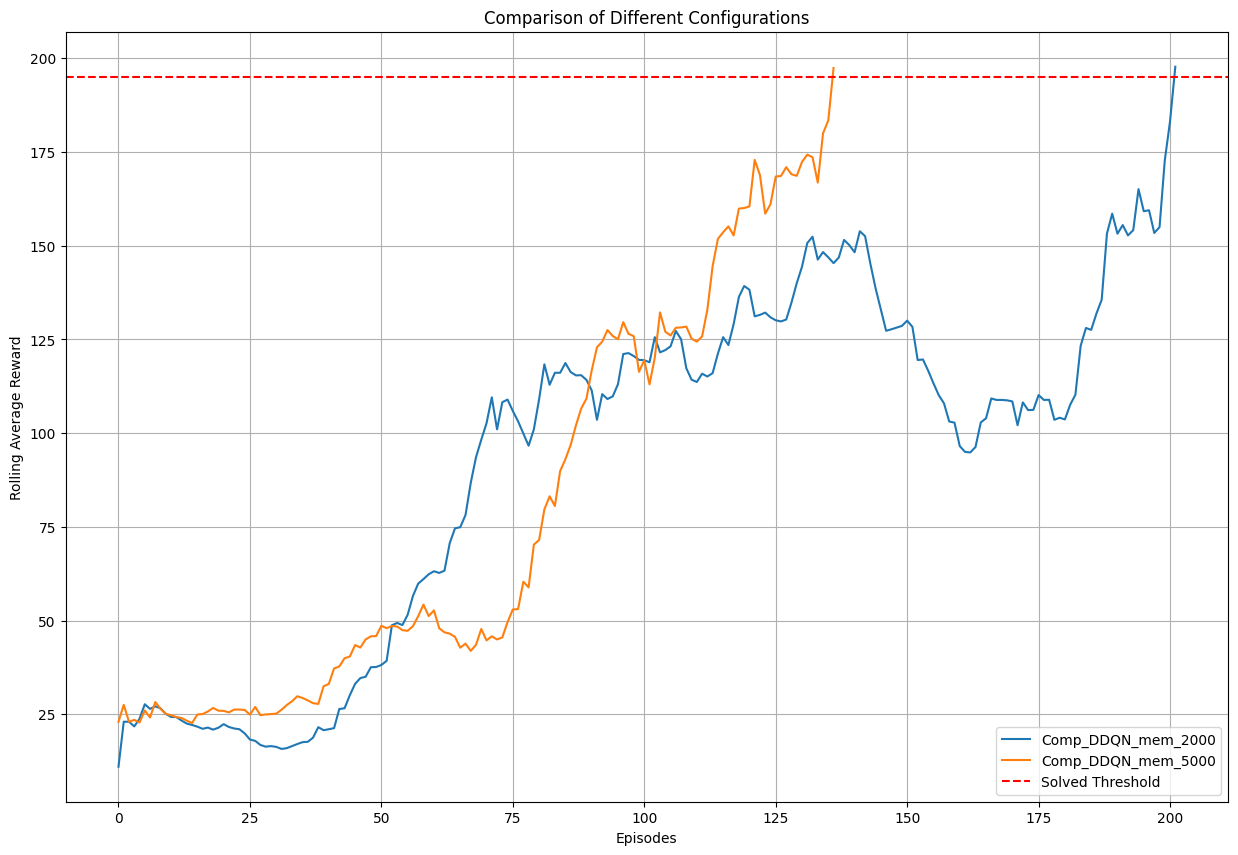

In [ ]:
# === Define Experiments ===
experiments = [
    # Network structure comparison
    #ExperimentConfig(network_structure=(16, 32), name="DDQN_16-32"),
    #ExperimentConfig(network_structure=(24, 24), name="DDQN_24-24"),
    #ExperimentConfig(network_structure=(32, 32), name="DDQN_32-32"),

    # # Replay buffer comparison
    # ExperimentConfig(memory_size=1000, name="DDQN_mem_1000"),
    ExperimentConfig(memory_size=2000, name="Comp_DDQN_mem_2000"),
    ExperimentConfig(memory_size=5000, name="Comp_DDQN_mem_5000"),

    # # Learning rate comparison
    # ExperimentConfig(learning_rate=0.0001, name="DDQN_lr_0.0001"),
    # #ExperimentConfig(learning_rate=0.001, name="DDQN_lr_0.001"),
    # ExperimentConfig(learning_rate=0.01, name="DDQN_lr_0.01"),

    # # Epsilon decay comparison
    # ExperimentConfig(epsilon_decay=0.95, name="DDQN_eps_0.95"),
    # #ExperimentConfig(epsilon_decay=0.99, name="DDQN_eps_0.99"),
    #ExperimentConfig(epsilon_decay=0.995, name="DDQN_eps_0.995"),
]

# === Run All Experiments ===
results = []
for config in experiments:
    print(f"\nRunning experiment: {config.name}")
    result = run_experiment(config)
    results.append(result)

# === Find Best Model ===
best_model = find_best_model(results)

# === Plot Results ===
def plot_experiment_results(results):
    plt.figure(figsize=(15, 10))
    for result in results:
        plt.plot(result['rolling_avg'], label=f"{result['config'].name}")
    plt.axhline(y=solved_threshold, color='red', linestyle='--', label='Solved Threshold')
    plt.title('Comparison of Different Configurations')
    plt.xlabel('Episodes')
    plt.ylabel('Rolling Average Reward')
    plt.legend()
    plt.grid()
    plt.show()

# === Print Summary ===
print("\nExperiment Results Summary:")
print("-------------------------")
for result in results:
    config = result['config']
    print(f"\nConfiguration: {config.name}")
    print(f"Network Structure: {config.network_structure}")
    print(f"Memory Size: {config.memory_size}")
    print(f"Learning Rate: {config.learning_rate}")
    print(f"Epsilon Decay: {config.epsilon_decay}")
    print(f"Episodes to Solve: {result['episodes_to_solve']}")
    print(f"Training Duration: {result['training_duration']:.2f} minutes")
    print(f"Model File: {result['model_filename']}")

plot_experiment_results(results)

In my experiments using Double DQN on the CartPole environment, the best-performing neural network structure was (64, 64), as it provided both stability and capacity for learning. The most successful configuration used a replay buffer size of 5000, a learning rate of 0.001, and an epsilon decay of 0.99, solving the environment in just 137 episodes and completing training in approximately 38.5 minutes. Comparing buffer sizes showed that larger buffers (5000) improved performance and led to faster convergence than smaller ones (2000), which took longer to solve (202 episodes, 61.7 minutes). The learning rate of 0.001 worked best, balancing speed and stability, while 0.99 proved to be an effective epsilon decay rate, ensuring a smooth shift from exploration to exploitation. Overall, larger replay memory and the right balance of exploration helped achieve optimal results. Also I'm not sure why it was taking so long when the DQN seemed to be quicker.